# Deep Recommender: Item Representation Learning Using Node2Vec

In this notebook, we build a non-personalized graph recommendation engine that uses Node2Vec model to learn item embeddings. This notebook is based on Khalid Salama's implementation [1]. 

### Data
We use `MovieLens 100K` (Latest Small version) dataset. See `datasets.md` for details.

### References
1. Khalid Salama -- Graph representation learning with node2vec, 2021

In [17]:
import os
import math
from zipfile import ZipFile
import warnings
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from collections import defaultdict
import math
import networkx as nx
import random
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from tabulate import tabulate

import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams.update({'pdf.fonttype': 'truetype'})
warnings.simplefilter("ignore")

print("Keras version " + tf.keras.__version__)
print("Tensorflow version " + tf.__version__)

Keras version 2.6.0
Tensorflow version 2.6.0


In [8]:
#
# Helper functions
#
def print_df(df, col_width = 10, rows = 10, max_cols = 10):
    def short_srt(x):
        return x if len(x) < col_width else x[:col_width-3] + "..."
    df_short = df.head(rows).applymap(lambda x: short_srt(str(x)))
    
    if len(df_short.columns) > max_cols:
        df_short = df_short.iloc[:, 0:max_cols-1]
        df_short['...'] = '...'
    
    print(tabulate(df_short, headers='keys', tablefmt='psql'))
    print(f'{len(df)} rows x {len(df.columns)} columns')

# Step 1: Load Data

In [309]:
def load_movielens_100k_latest():
    base_data_path = '~/ALGO/tensor-house-data/recommendations/movie-lens-latest-small/'

    items = pd.read_csv(base_data_path + 'movies.csv.zip', 
                         compression='zip', 
                         sep=',',
                         usecols=[0,1],
                         names=['itemId', 'name'], 
                         header=1)
    items['itemId'] = items['itemId'].apply(lambda x: f'item_{x}')

    ratings = pd.read_csv(base_data_path + 'ratings.csv.zip', 
                          compression='zip', 
                          sep=',',
                          usecols=[0, 1, 2],
                          names=['userId', 'itemId', 'rating'], 
                          header=1)
    ratings['rating'] = ratings['rating'].apply(lambda x: float(x))
    ratings['itemId'] = ratings['itemId'].apply(lambda x: f'item_{x}')

    return items, ratings

def load_movielens_100k():
    base_data_path = '~/ALGO/tensor-house-data/recommendations/movie-lens-100k/'

    items = pd.read_csv(base_data_path + 'u.item.zip', 
                         compression='zip', 
                         sep='|',
                         usecols=[0,1],
                         names=['itemId', 'name'], 
                         header=None)
    items['itemId'] = items['itemId'].apply(lambda x: f'item_{x}')

    ratings = pd.read_csv(base_data_path + 'u.data.zip', 
                          compression='zip', 
                          sep='\t',
                          usecols=[0,1,2],
                          names=['userId', 'itemId', 'rating'], 
                          header=None)
    ratings['rating'] = ratings['rating'].apply(lambda x: float(x))
    ratings['itemId'] = ratings['itemId'].apply(lambda x: f'item_{x}')

    return items, ratings
    
items, ratings = load_movielens_100k_latest()
print_df(items, col_width=30)
print_df(ratings, col_width=30)

def get_item_name_by_id(itemId):
    return list(items[items.itemId == itemId].name)[0]

def get_item_id_by_name(name):
    return list(items[items.name == name].itemId)[0]

+----+----------+--------------------------------+
|    | itemId   | name                           |
|----+----------+--------------------------------|
|  0 | item_2   | Jumanji (1995)                 |
|  1 | item_3   | Grumpier Old Men (1995)        |
|  2 | item_4   | Waiting to Exhale (1995)       |
|  3 | item_5   | Father of the Bride Part II... |
|  4 | item_6   | Heat (1995)                    |
|  5 | item_7   | Sabrina (1995)                 |
|  6 | item_8   | Tom and Huck (1995)            |
|  7 | item_9   | Sudden Death (1995)            |
|  8 | item_10  | GoldenEye (1995)               |
|  9 | item_11  | American President, The (19... |
+----+----------+--------------------------------+
9741 rows x 2 columns
+----+----------+----------+----------+
|    |   userId | itemId   |   rating |
|----+----------+----------+----------|
|  0 |        1 | item_3   |        4 |
|  1 |        1 | item_6   |        4 |
|  2 |        1 | item_47  |        5 |
|  3 |        1 | item_5

# Step 2: Create the Item Graph

In [428]:
#
# Create the weighted edges between items
#
min_rating = 5
pair_frequency = defaultdict(int)
item_frequency = defaultdict(int)

#
# Filter instances where rating is greater than or equal to min_rating
#
rated_items = ratings[ratings.rating >= min_rating]

#
# Group items by user
#
items_grouped_by_users = list(rated_items.groupby("userId"))

for group in tqdm(
    items_grouped_by_users,
    position=0,
    leave=True,
    desc="Compute item frequencies",
):
    u_items = list(group[1]["itemId"])

    for i in range(len(u_items)):
        item_frequency[u_items[i]] += 1
        for j in range(i + 1, len(u_items)):
            x = min(u_items[i], u_items[j])
            y = max(u_items[i], u_items[j])
            pair_frequency[(x, y)] += 1

#
# Create the graph
#
min_weight = 10
D = math.log(sum(item_frequency.values()))

items_graph = nx.Graph()
for pair in tqdm(
    pair_frequency, position=0, leave=True, desc="Creating the item graph"
):
    x, y = pair
    xy_frequency = pair_frequency[pair]
    x_frequency = item_frequency[x]
    y_frequency = item_frequency[y]
    pmi = math.log(xy_frequency) - math.log(x_frequency) - math.log(y_frequency) + D
    weight = pmi * xy_frequency

    if weight >= min_weight:
        items_graph.add_edge(x, y, weight=weight, frequency=xy_frequency)

                
print("Total number of graph nodes:", items_graph.number_of_nodes())
print("Total number of graph edges:", items_graph.number_of_edges())

degrees = []
for node in items_graph.nodes:
    degrees.append(items_graph.degree[node])
print("Average node degree:", round(sum(degrees) / len(degrees), 2))

#
# Create a mapping between nodes and item Ids
#
vocabulary = ["NA"] + list(items_graph.nodes)
vocabulary_lookup = {token: idx for idx, token in enumerate(vocabulary)}

Creating the item graph: 100%|██████████| 298586/298586 [00:00<00:00, 642655.01it/s]

Total number of graph nodes: 1405
Total number of graph edges: 40043
Average node degree: 57.0


# Step 3: Visualize the Item Graph

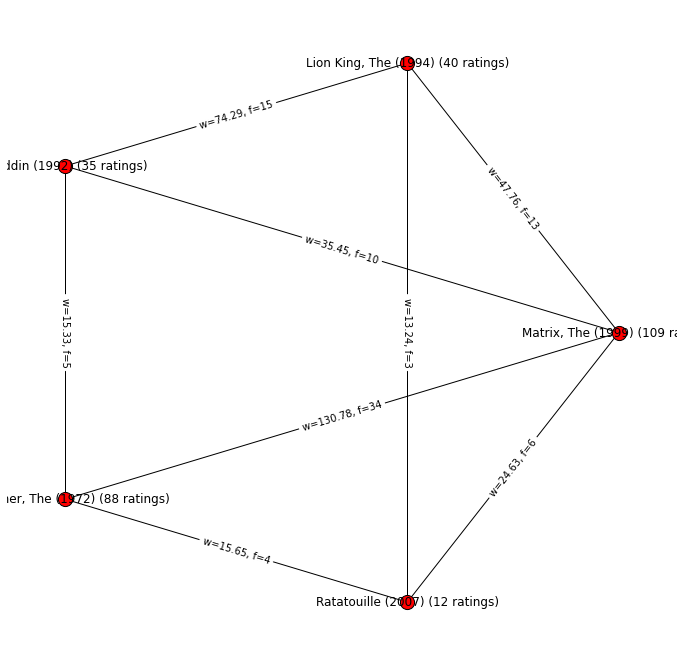

In [431]:
selected_items = [
    "Matrix, The (1999)",
    "Godfather, The (1972)",
    "Lion King, The (1994)",
    "Aladdin (1992)",
    "Ratatouille (2007)"
]

selected_nodes = {
    item_name: get_item_id_by_name(item_name) 
    for item_name in selected_items
}
ivd = {v: f'{k} ({item_frequency[v]} ratings)' for k, v in selected_nodes.items()}
    
G = items_graph.subgraph(selected_nodes.values())
G = nx.relabel_nodes(G, ivd)

edge_labels = {}
for e in G.edges:
    weight = nx.get_edge_attributes(G, 'weight')[e]
    frequency = nx.get_edge_attributes(G, 'frequency')[e]
    edge_labels[e] = f'w={weight:.2f}, f={frequency}'

fig, ax = plt.subplots(1, 1, figsize=(12,12))
pos = nx.circular_layout(G)
nx.draw_networkx_nodes(G, pos, ax=ax, node_color='red', edgecolors='black', node_size = 200)
nx.draw_networkx_edges(G, pos, ax=ax, arrows=False)
nx.draw_networkx_labels(G, pos, ax=ax)
nx.draw_networkx_edge_labels(G, pos, ax=ax, edge_labels=edge_labels)
plt.axis('off')
plt.show()

# Sampling Random Walks

In [430]:
def next_step(graph, previous, current, p, q):
    neighbors = list(graph.neighbors(current))

    weights = []
    
    for neighbor in neighbors:
        if neighbor == previous:
            # Control the probability to return to the previous node.
            weights.append(graph[current][neighbor]["weight"] / p)
        elif graph.has_edge(neighbor, previous):
            # The probability of visiting a local node.
            weights.append(graph[current][neighbor]["weight"])
        else:
            # Control the probability to move forward.
            weights.append(graph[current][neighbor]["weight"] / q)

    # Normalize the probabilities of visiting each neighbor
    weight_sum = sum(weights)
    probabilities = [weight / weight_sum for weight in weights]
    
    # Probabilistically select a neighbor to visit
    next = np.random.choice(neighbors, size=1, p=probabilities)[0]
    return next


def random_walk(graph, num_walks, num_steps, p, q):
    walks = []
    nodes = list(graph.nodes())

    for walk_iteration in range(num_walks):
        random.shuffle(nodes)

        for node in tqdm(
            nodes,
            position=0,
            leave=True,
            desc=f"Random walks iteration {walk_iteration + 1} of {num_walks}",
        ):
            
            walk = [node]
            
            while len(walk) < num_steps:
                current = walk[-1]
                previous = walk[-2] if len(walk) > 1 else None
                next = next_step(graph, previous, current, p, q)
                walk.append(next)
                
            # Replace node ids (item ids) in the walk with token ids.
            walk = [vocabulary_lookup[token] for token in walk]

            walks.append(walk)
    return walks



# Random walk return parameter.
p = 1
# Random walk in-out parameter.
q = 1
# Number of iterations of random walks.
num_walks = 5
# Number of steps of each random walk.
num_steps = 10
walks = random_walk(items_graph, num_walks, num_steps, p, q)

print("Number of walks generated:", len(walks))

Random walks iteration 5 of 5: 100%|██████████| 1405/1405 [00:05<00:00, 274.45it/s]

Number of walks generated: 7025


# Create Training Dataset Using Negative Sampling

In [416]:
def generate_examples(sequences, window_size, num_negative_samples, vocabulary_size):
    example_weights = defaultdict(int)

    for sequence in tqdm(
        sequences,
        position=0,
        leave=True,
        desc=f"Generating postive and negative examples",
    ):
        # Generate positive and negative skip-gram pairs for a sequence (walk)
        pairs, labels = keras.preprocessing.sequence.skipgrams(
            sequence,
            vocabulary_size=vocabulary_size,
            window_size=window_size,
            negative_samples=num_negative_samples,
        )
        for idx in range(len(pairs)):
            pair = pairs[idx]
            label = labels[idx]
            target, context = min(pair[0], pair[1]), max(pair[0], pair[1])
            if target == context:
                continue
            entry = (target, context, label)
            example_weights[entry] += 1

    targets, contexts, labels, weights = [], [], [], []
    for entry in example_weights:
        weight = example_weights[entry]
        target, context, label = entry
        targets.append(target)
        contexts.append(context)
        labels.append(label)
        weights.append(weight)

    return np.array(targets), np.array(contexts), np.array(labels), np.array(weights)


num_negative_samples = 4
targets, contexts, labels, weights = generate_examples(
    sequences=walks,
    window_size=num_steps,
    num_negative_samples=num_negative_samples,
    vocabulary_size=len(vocabulary),
)

print(f"Targets shape: {targets.shape}")
print(f"Contexts shape: {contexts.shape}")
print(f"Labels shape: {labels.shape}")
print(f"Weights shape: {weights.shape}")


batch_size = 1024
def create_dataset(targets, contexts, labels, weights, batch_size):
    inputs = {
        "target": targets,
        "context": contexts,
    }
    dataset = tf.data.Dataset.from_tensor_slices((inputs, labels, weights))
    dataset = dataset.shuffle(buffer_size=batch_size * 2)
    dataset = dataset.batch(batch_size, drop_remainder=True)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset

#
# Each record in the dataset has the following format:
# (target_node_id, context_node_id), interaction_label_0_1, sample_weight
#
dataset = create_dataset(
    targets=targets,
    contexts=contexts,
    labels=labels,
    weights=weights,
    batch_size=batch_size,
)

Generating postive and negative examples: 100%|██████████| 7025/7025 [00:09<00:00, 737.16it/s]


Targets shape: (882834,)
Contexts shape: (882834,)
Labels shape: (882834,)
Weights shape: (882834,)


# Model Training

Epoch 1/10
862/862 [==============================] - 4s 4ms/step - loss: 2.4469
Epoch 2/10
862/862 [==============================] - 4s 4ms/step - loss: 2.3399
Epoch 3/10
862/862 [==============================] - 3s 4ms/step - loss: 2.3324
Epoch 4/10
862/862 [==============================] - 4s 4ms/step - loss: 2.3279
Epoch 5/10
862/862 [==============================] - 4s 5ms/step - loss: 2.3234
Epoch 6/10
862/862 [==============================] - 4s 5ms/step - loss: 2.3195
Epoch 7/10
862/862 [==============================] - 4s 5ms/step - loss: 2.3163
Epoch 8/10
862/862 [==============================] - 4s 4ms/step - loss: 2.3136
Epoch 9/10
862/862 [==============================] - 4s 4ms/step - loss: 2.3110
Epoch 10/10
862/862 [==============================] - 3s 4ms/step - loss: 2.3085


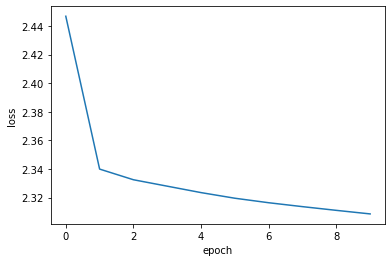

In [417]:
learning_rate = 0.001
embedding_dim = 50
num_epochs = 10

def create_model(vocabulary_size, embedding_dim):
    inputs = {
        "target": layers.Input(name="target", shape=(), dtype="int32"),
        "context": layers.Input(name="context", shape=(), dtype="int32"),
    }
    
    embed_item = layers.Embedding(
        input_dim=vocabulary_size,
        output_dim=embedding_dim,
        embeddings_initializer="he_normal",
        embeddings_regularizer=keras.regularizers.l2(1e-6),
        name="item_embeddings",
    )
    
    target_embeddings = embed_item(inputs["target"])
    
    context_embeddings = embed_item(inputs["context"])
    
    # Compute dot similarity between target and context embeddings.
    logits = layers.Dot(axes=1, normalize=False, name="dot_similarity")(
        [target_embeddings, context_embeddings]
    )
    

    model = keras.Model(inputs=inputs, outputs=logits)
    return model

model = create_model(len(vocabulary), embedding_dim)
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
)

history = model.fit(dataset, epochs=num_epochs)

plt.plot(history.history["loss"])
plt.ylabel("loss")
plt.xlabel("epoch")
plt.show()

# Model Evaluation

In [418]:
item_embeddings = model.get_layer("item_embeddings").get_weights()[0]
print("Embeddings shape:", item_embeddings.shape)

query_items = [
    "Matrix, The (1999)",
    "Godfather, The (1972)",
    "Lion King, The (1994)",
    "Aladdin (1992)",
    "Ratatouille (2007)"
]

query_embeddings = []

for item_name in query_items:
    itemId = get_item_id_by_name(item_name)
    token_id = vocabulary_lookup[itemId]
    item_embedding = item_embeddings[token_id]
    query_embeddings.append(item_embedding)

query_embeddings = np.array(query_embeddings)

similarities = tf.linalg.matmul(
    tf.math.l2_normalize(query_embeddings),
    tf.math.l2_normalize(item_embeddings),
    transpose_b=True,
)

_, indices = tf.math.top_k(similarities, k=5)
indices = indices.numpy().tolist()

for idx, name in enumerate(query_items):
    print(name)
    print("".rjust(len(name), "-"))
    similar_tokens = indices[idx]
    for token in similar_tokens:
        similar_itemId = vocabulary[token]
        similar_name = get_item_name_by_id(similar_itemId)
        print(f"- {similar_name}")
    print()

Embeddings shape: (1406, 50)
Matrix, The (1999)
------------------
- Matrix, The (1999)
- Lord of the Rings: The Fellowship of the Ring, The (2001)
- Lord of the Rings: The Return of the King, The (2003)
- Star Wars: Episode V - The Empire Strikes Back (1980)
- Star Wars: Episode VI - Return of the Jedi (1983)

Godfather, The (1972)
---------------------
- Godfather, The (1972)
- Godfather: Part II, The (1974)
- Star Wars: Episode V - The Empire Strikes Back (1980)
- Apocalypse Now (1979)
- Fargo (1996)

Lion King, The (1994)
---------------------
- Lion King, The (1994)
- Jurassic Park (1993)
- Aladdin (1992)
- Apollo 13 (1995)
- Braveheart (1995)

Aladdin (1992)
--------------
- Aladdin (1992)
- Lion King, The (1994)
- Apollo 13 (1995)
- Beauty and the Beast (1991)
- Jurassic Park (1993)

Ratatouille (2007)
------------------
- Ratatouille (2007)
- Up (2009)
- Monsters, Inc. (2001)
- Guardians of the Galaxy (2014)
- Casino Royale (2006)

